In [1]:
# Michael Wasserstein
# Plot_Scatter_Obs_modeled_Precip.py
# 11/6/2024

# Script gets observed precipitation from Synoptic API
# As well as modeled preicpitation
# and then it plots both as a scatter

####### Usage #########
# Conda environment - py37
# python /uufs/chpc.utah.edu/common/home/u1371671/WRF/Plotting_Scripts_To_Use_Now/Plot_Precip_Map_WRF_Synoptic_API.py -r 2 -p 2
# -r represents the run number you want to plot
# -p represents the path of interest

import os, sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u1371671/')
from map_script import *
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors, ListedColormap, LinearSegmentedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.dates as mdates
import pyart
import metpy.calc as mpcalc
from metpy.units import units
import cartopy.feature as cfeature

import numpy as np
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair, get_cartopy, ALL_TIMES)
import wrf
import glob
import pandas as pd
import datetime
from datetime import datetime


import urllib.request as req
import os.path
import json
import urllib

# ######## User input arguments #############
# import argparse
# parser = argparse.ArgumentParser()

# parser.add_argument("-r", "--run", help="WRF run of interest")
# parser.add_argument("-p", "--path", help="Wrf path - where is data (1 or 2")

# args = parser.parse_args()

# ###########################
# ##### stuff for WRF  ######
# ###########################
# # Get user inputs
# run = str(args.run)
# path = int(args.path)
# print('Plotting data for run', run,)

run = '18'
path = 12

# Leading zeros
run_number = '{}'.format(run).zfill(2)

# Get the timing for the run (user input)
if path == 1:
    time_start = '202212120000'
    time_end = '202212150000'
elif (path == 2) or (path == 6) or (path == 12):
    time_start = '201903221200'  # verify this is right
    time_end = '201903230600'
    if int(run) >= 14:
        time_start = '201903221200'  # verify this is right
        time_end = '201903230200'
    if run == '15':
        time_start = '201903220000'  # verify this truis right
        time_end = '201903230200'
elif (path == 9) or (path == 8):
    time_start = '202212130000'  # verify this is right
    time_end = '202212140600'

plot_d04 = False # do you want to plot data for d04
time_offset = False # do you want time offsetting?
time_offset_minutes = 45 # Positive value indicatees that all the wrf times will become 45 minutes later
time_offset_hours = 0

# TImes for the title
start_time_title = datetime.strftime(pd.to_datetime(time_start), '%b %-d, %Y %H:%M UTC')
end_time_title = datetime.strftime(pd.to_datetime(time_end), '%b %-d, %Y %H:%M UTC')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
############################
## stuff for synoptic API ##
############################
API_ROOT = "https://api.synopticdata.com/v2/"
API_TOKEN = "0d0f87d395244930af38c1460e0c1a0f"
within = 30 # how many minutes within the time of interest

# paths for data
if path ==1:
    base_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group12/michael/wrf/'
else:
    
    base_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group12/michael/wrf{}/'.format(path)
WRF_path = base_path + 'wrf_runs/wrf_{}/run/'.format(run_number)

# paths for saving fig
parent_dir = '/uufs/chpc.utah.edu/common/home/u1371671/WRF/'
Fig_dir = parent_dir + 'Figures_{}/wrf_{}/'.format(path,run_number)

# Make fig dir if it doesn't exist
if os.path.exists(Fig_dir) == False:
    os.mkdir(Fig_dir)

##################################################
#################WRF STUFF for domain 3########################
##################################################
domain = 3

# load in all the wrf output data files
data_files = glob.glob(WRF_path + '*wrfout_d0{}*'.format(domain)) # for the innermost domain
data_files.sort()

# Get the init times
init_time = Dataset(data_files[0]).SIMULATION_START_DATE
init_time = datetime.strptime(init_time, '%Y-%m-%d_%H:%M:%S')
init_time_str = datetime.strftime(init_time,  '%Y-%m-%d %H:%M:%SZ')

# Stuff for boundaries
geobounds = wrf.geo_bounds(wrfin=Dataset(data_files[0]))
bottom_latitude = geobounds.bottom_left.lat
left_longitude = geobounds.bottom_left.lon
top_latitude = geobounds.top_right.lat
right_longitude = geobounds.top_right.lon

# Load in all the wrf files
wrflist_d03 = [Dataset(file) for file in data_files]

# Extract variables of interest
rain_d03 = wrf.getvar(wrflist_d03, "RAINNC", timeidx=-1) # Get last time cause youre interested in the total
rainc_d03 = wrf.getvar(wrflist_d03, "RAINC", timeidx=-1) # Get last time cause youre interested in the total

# Compute total precipitation from convectivte and nonconvective parts
rain_d03_total = rain_d03 + rainc_d03

##################################################
#################API STUFF########################
##################################################

# String to use for api request - all stations in requested domain
bbox_string = f'{left_longitude},{bottom_latitude},{right_longitude},{top_latitude}'

# Get the total precipitation accumulation during the period of interest
api_request_url = os.path.join(API_ROOT, "stations/precip")            # https://docs.synopticdata.com/services/precipitation
api_request_url += "?bbox={}&start={}&end={}&pmode=totals&token={}".format(bbox_string, time_start, time_end, API_TOKEN)

# Read the api request
response = req.urlopen(api_request_url)
api_text_data = response.read() # read the api request

use_data = json.loads(api_text_data) # Now you can work with use_data because it is a dictionary of the data the API returned.


# Empty list to store data
stn_precip_accums, stn_lats, stn_lons = [],[],[],

# Loop through all the stations in the bounding box
for i in range(len(use_data['STATION'])): 
    
    # Get station data
    stn_data = use_data['STATION'][i]
    
    # Extract precipitation
    stn_precip_accum  = stn_data['OBSERVATIONS']['precipitation'][0]['total']
    
    # Extract latitude and longitude
    stn_lat, stn_lon = float(stn_data['LATITUDE']), float(stn_data['LONGITUDE'])
    
    # Add the data to your lists
    stn_precip_accums.append(stn_precip_accum)
    stn_lats.append(stn_lat)
    stn_lons.append(stn_lon)
    
# Convert to np.arrays
stn_precip_accums = np.array(stn_precip_accums)
stn_lats = np.array(stn_lats)
stn_lons = np.array(stn_lons)

# Get indicies that would sort the array
arg_sort = np.argsort(stn_precip_accums)

# Sort precipitation, lat, and lon # This will be beneficial for plotting cause highest amounts will plot on top
stn_precip_accums = stn_precip_accums[arg_sort]
stn_lats = stn_lats[arg_sort]
stn_lons = stn_lons[arg_sort]

In [3]:
ll_values = wrf.ll_to_xy(wrfin = wrflist_d03[0], latitude = stn_lats, longitude = stn_lons) # THe xy values for the observations, for the wrf model

rain_scatter = rain_d03_total[ll_values[1], ll_values[0]].values # THis will give you the rainfall corresponding to each gridpoint from obs

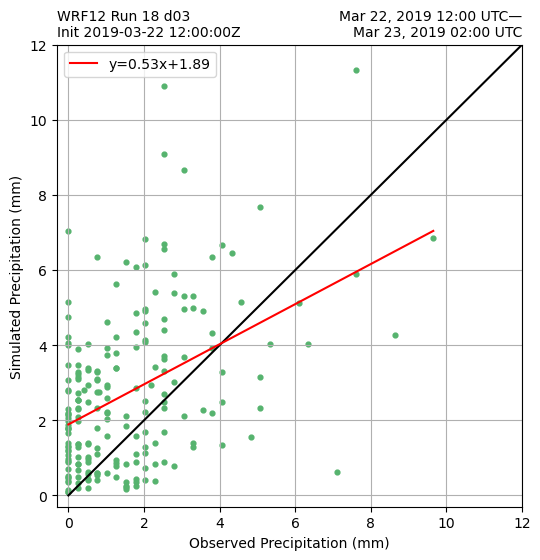

In [4]:
save_path = Fig_dir + 'WRF_Synoptic_API_scattergram.png'

# Create figure
fig, ax = plt.subplots(1,1, figsize = (6,6), facecolor = 'white', edgecolor = 'k')

# Plot scatter
ax.scatter(stn_precip_accums, rain_scatter, c = '#56b36e', s = 12)

# Plot 1 to 1 line
ax.plot(np.arange(0,15,1), np.arange(0,15,1), color = 'k')

# Compute regression line (y = mx + b)
m, b = np.polyfit(stn_precip_accums, rain_scatter, 1)  # Linear regression (degree=1)

# Generate the regression line
regression_line = m * stn_precip_accums + b
plt.plot(stn_precip_accums, regression_line, color='red', label=f'y={m:.2f}x+{b:.2f}')

# Set axis limits
ax.set_ylim(-0.3,12)
ax.set_xlim(-0.3,12)

# Set labels
ax.set_xlabel('Observed Precipitation (mm)')
ax.set_ylabel('Simulated Precipitation (mm)')

# Add a title
ax.set_title("WRF{} Run {} d0{}\nInit {}".format(path, run, domain, init_time_str), fontsize = 10, loc = 'left',)
ax.set_title("{}\u2014\n{}".format(start_time_title,
                                        end_time_title), fontsize = 10, loc = 'right',)

plt.legend()

# Add a grid
plt.grid()

# Save show close
plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

# Make a plot that doesn't include the zeros for observed precipitation

In [5]:
ind_where_not_0 = np.where(stn_precip_accums != 0)[0]

In [6]:
rain_scatter_no_0 = rain_scatter[ind_where_not_0]
stn_precip_accums_no_0 = stn_precip_accums[ind_where_not_0]

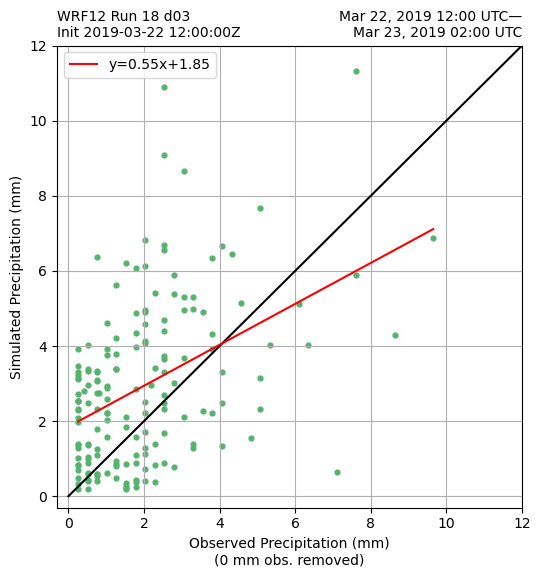

In [7]:
save_path = Fig_dir + 'WRF_Synoptic_API_scattergram_no_zero.png'

# Create figure
fig, ax = plt.subplots(1,1, figsize = (6,6), facecolor = 'white', edgecolor = 'k')

# Plot scatter
ax.scatter(stn_precip_accums_no_0, rain_scatter_no_0, c = '#56b36e', s = 12)

# Plot 1 to 1 line
ax.plot(np.arange(0,15,1), np.arange(0,15,1), color = 'k')

# Compute regression line (y = mx + b)
m, b = np.polyfit(stn_precip_accums_no_0, rain_scatter_no_0, 1)  # Linear regression (degree=1)

# Generate the regression line
regression_line = m * stn_precip_accums_no_0 + b
plt.plot(stn_precip_accums_no_0, regression_line, color='red', label=f'y={m:.2f}x+{b:.2f}')

# Set axis limits
ax.set_ylim(-0.3,12)
ax.set_xlim(-0.3,12)

# Set labels
ax.set_xlabel('Observed Precipitation (mm)\n(0 mm obs. removed)')
ax.set_ylabel('Simulated Precipitation (mm)')

# Add a title
ax.set_title("WRF{} Run {} d0{}\nInit {}".format(path, run, domain, init_time_str), fontsize = 10, loc = 'left',)
ax.set_title("{}\u2014\n{}".format(start_time_title,
                                        end_time_title), fontsize = 10, loc = 'right',)

plt.legend()


# Add a grid
plt.grid()

# Save show close
plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()